In [1]:
from typing import Callable, Iterator, Sequence
from tqdm import tqdm
import functools

import os
import numpy as np
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex

## Dataset loading

In [2]:
data_dir = 'dataset'
X_train = np.load(os.path.join(data_dir, 'X_train_checkerboard.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test_checkerboard.npy'))

## Define MLP score function

In [38]:
Activation = Callable[[jax.Array], jax.Array]

class MLP(nn.Module):
    
    features: Sequence[int]  # Number of neurons in each layer
    activation: Activation = nn.swish

    @nn.compact
    def __call__(self, x: jax.Array) -> jax.Array:
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        x = nn.Dense(self.features[-1])(x)
        return x.squeeze()  # TODO: Check if valid

model = MLP(features=[64, 64, 1])
print(model.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))


                                 MLP Summary                                 
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs        ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[1,2]  │ float32[]     │                        │
├─────────┼────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,2]  │ float32[1,64] │ bias: float32[64]      │
│         │        │               │               │ kernel: float32[2,64]  │
│         │        │               │               │                        │
│         │        │               │               │ 192 (768 B)            │
├─────────┼────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,64] │ float32[1,64] │ bias: float32[64]      │
│         │        │               │               │ kernel: fl

## Define the cross-entropy loss gradient

In [70]:
@functools.partial(jax.jit, static_argnames=("num_steps",))
def langevin_sampling(
    params: chex.ArrayTree,
    key: chex.PRNGKey,
    step_size: float,
    initial_samples: jax.Array,
    num_steps: int,
) -> jax.Array:

    def scan_fn(carry, _):
        states, key = carry
        key, sk = jax.random.split(key)
        noise = jax.random.normal(sk, shape=states.shape)
        score = jax.vmap(jax.grad(lambda x: model.apply(params, x)))(states)  # TODO: Check
        next_states = states + step_size * score + jnp.sqrt(2 * step_size) * noise
        return (next_states, key), None

    states = initial_samples
    (states, _), _ = jax.lax.scan(scan_fn, (states, key), jnp.arange(num_steps))
    return states

In [76]:
def ce_loss_grad(params: chex.ArrayTree, batch: jax.Array, key: chex.PRNGKey) -> float:
    # Sample from model
    key1, key2 = jax.random.split(key)
    batch_model = langevin_sampling(params, key1, 5e-3, 2 * jax.random.normal(key2, shape=batch.shape), 1000)

    # Apply model and compute gradient for each sample
    f = lambda params, x: model.apply(params, x)
    df_data = jax.vmap(jax.grad(f), in_axes=(None, 0))(params, batch)
    df_model = jax.vmap(jax.grad(f), in_axes=(None, 0))(params, batch_model)
    grad = jax.tree.map(jnp.subtract, df_model, df_data)  # -(df_data - df_model)

    # Sum gradients across samples
    grad = jax.tree.map(lambda x: jnp.sum(x, axis=0), grad)

    return grad

## Train the model

In [77]:
optimizer = optax.adam(learning_rate=1e-3)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))

@jax.jit
def do_batch_update(
    batch: jax.Array,
    params: chex.ArrayTree, 
    opt_state: optax.OptState,  # Optimizer state
    key: chex.PRNGKey,
) -> tuple[float, chex.ArrayTree, optax.OptState]:
    grad = ce_loss_grad(params, batch, key)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state


class BatchManager(Iterator[np.ndarray]):
    
    def __init__(
        self,
        data: np.ndarray,
        batch_size: int,
        key: chex.PRNGKey
    ):
        batch_size = min(batch_size, len(data))
        self._num_batches = len(data) // batch_size
        self._batch_idx = None
        self._batch_size = batch_size
        self._key = hk.PRNGSequence(key)
        self._data = data
        self._reset()

    @property
    def num_batches(self) -> int:
        return self._num_batches

    def _reset(self) -> None:
        self._perm = np.array(jax.random.permutation(next(self._key), np.arange(len(self._data))))
        self._batch_idx = 0

    def __next__(self) -> np.ndarray:
        assert self._batch_idx is not None
        assert self._batch_idx >= 0 and self._batch_idx < self._num_batches
        inds = self._perm[self._batch_idx * self._batch_size : (self._batch_idx + 1) * self._batch_size]
        batch = self._data[inds]
        self._batch_idx += 1
        if self._batch_idx >= self._num_batches:
            self._reset()
        return batch

In [81]:
# Parameters
num_epochs = 500
batch_size = 128
params = model.init(next(prng_seq), X_train[:1, ...])
opt_state = optimizer.init(params)
bm = BatchManager(X_train, batch_size, key=next(prng_seq))

# train_losses = []
# test_losses = []
for epoch in tqdm(range(num_epochs), "Epoch"):
    # Perform batch updates
    batch_loss = 0
    for _ in range(bm.num_batches):
        batch = next(bm)
        params, opt_state = do_batch_update(batch, params, opt_state, key=next(prng_seq))
        # batch_loss += train_loss

    # Compute test set loss
    # test_loss = ce_loss_grad(params, X_test, key=next(prng_seq), std=0.1, k=100)
    # train_losses.append(batch_loss / X_train.shape[0])
    # test_losses.append(test_loss / X_test.shape[0])
    
# train_losses = np.array(train_losses)
# test_losses = np.array(test_losses)

Epoch: 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


## Sample from the model

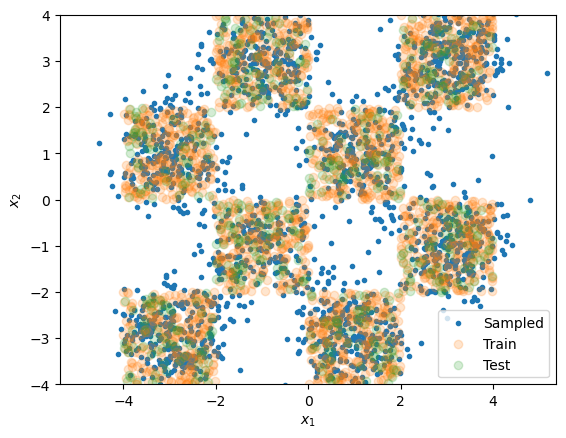

In [82]:
# Generate samples
samples = langevin_sampling(
    params,
    next(prng_seq),
    5e-3,
    2 * jax.random.normal(next(prng_seq), shape=(2000, 2)),
    1000)

# Plot samples
plt.scatter(samples[:, 0], samples[:, 1], marker='.', label='Sampled')
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2, marker='o', label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.2, marker='o', label='Test')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis('equal')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.legend()
plt.show() 